In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Gives the value of clique function for input bitstring
def max_clique(x, G):
    
    # x is the input bit string. eg: '1010'
    fn = 0
    x = np.array(list(x), dtype=int)
    for i in range(len(G.nodes())):
        fn = fn - x[i]
    for pair in list(G.edges()):
        if x[pair[0]] + x[pair[1]] > 1:
            fn = fn + 2*x[pair[0]]*x[pair[1]]
    return fn

# Computes Expectation Value
def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = max_clique(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [3]:
# Basic QAOA Function which returns counts
def basic_qaoa(G, theta) :

    # Basic QAOA circuit for Max Clique Problem
    def create_qaoa_circ(G, theta):
    
        # Division of input array Theta
        nqubits = len(G.nodes())
        nlayers = len(theta)//3  # number of alternating unitaries
        beta = theta[:nlayers]
        k = theta[nlayers:]
        alpha = k[:nlayers]
        gamma = k[nlayers:]

        qc = QuantumCircuit(nqubits)

        # initial_state
        qc.h(range(nqubits))

        for irep in range(nlayers):
            
            # problem unitary
            for i in range(nqubits):
                qc.rz(2 * alpha[irep], i)
            for pair in list(G.edges()):
                qc.rzz(2 * gamma[irep], pair[0], pair[1])
            qc.barrier()
            
            # mixer unitary
            for qubit in range(nqubits):
                qc.rx(2 * beta[irep], qubit)
            qc.barrier()

        qc.measure_all()
        return qc

    def get_expectation_QAOA(graph, shots=512):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = shots
        def execute_circ(theta):
            qc = create_qaoa_circ(graph, theta)
            counts = backend.run(qc, seed_simulator=10,
                                 nshots=512).result().get_counts()
            return compute_expectation(counts, graph)
        return execute_circ
    
    global qc_basic
    qc_basic = create_qaoa_circ(G, theta)
    
    # Optimizing Parameters for Basic QAOA
    expectation = get_expectation_QAOA(G)
    global res_basic
    res_basic = minimize(expectation, theta, method='COBYLA')

    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_qaoa_circ(G, res_basic.x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    return counts

In [4]:
# Multi-Angle QAOA Function which returns counts
def multi_angle_qaoa(G, theta) :
    
    # Multi-Angle QAOA circuit for Max CLique Problem
    def create_maqaoa_circ(G, theta):   
        nqubits = len(G.nodes()) 
        qc = QuantumCircuit(nqubits)
        clauses = len(G.edges())
        nlayers = len(theta)//((nqubits*2)+clauses)
        beta = np.reshape(theta[:nlayers*nqubits], (nlayers,nqubits))
        gamma = np.reshape(theta[nlayers*nqubits:], (nlayers,nqubits+clauses))
    
        for i in range(nqubits):
            qc.h(i)
    
        for irep in range(nlayers):
            k=0
            
            # problem unitary
            for i in range(nqubits):
                qc.rz(2 * gamma[irep,k], i)
                k+=1
        
            for pair in list(G.edges()):
                qc.rzz(2 * gamma[irep,k], pair[0], pair[1])
                k+=1
            qc.barrier()
            
            # mixer unitary
            for i in range(nqubits):
                qc.rx(2 * beta[irep,i], i)
            qc.barrier()
        
        qc.measure_all()
        return qc
    
    def get_expectation_MAQAOA(G, shots=512):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = shots
    
        def execute_circ(theta):
        
            qc = create_maqaoa_circ(G, theta)
            counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
            return compute_expectation(counts, G)
    
        return execute_circ
    
    global qc_multi
    qc_multi = create_maqaoa_circ(G, theta)
    
    # Optimizing Parameters for Basic QAOA
    expectation = get_expectation_MAQAOA(G)
    global res_multi
    res_multi = minimize(expectation, theta, method='COBYLA')

    
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512

    qc_res = create_maqaoa_circ(G, res_multi.x)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    return counts

Number of Nodes =  6
Number of Edges =  12


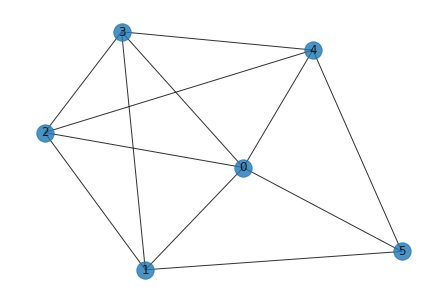

In [5]:
# Generating a Graph
import networkx as nx

# Edit edges as per desired Graph
edges = [(0,1), (0,2), (0,3), (0,4), (1,2), (1,3), (2,3), (3,4), (4,5), (0,5), (2,4), (1,5)]

G = nx.Graph(edges)

print("Number of Nodes = ", len(G.nodes()))
print("Number of Edges = ", len(G.edges()))
nx.draw(G, with_labels=True, alpha=0.8)

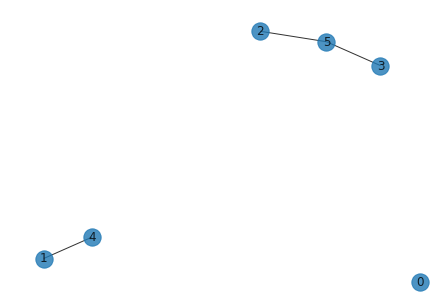

In [6]:
# Finding the Non-G graph with edges not contained in set G
w = nx.adjacency_matrix(G).todense()

# Adjacency matrix for Non-G graph
nodes = len(G.nodes())
non_w = np.ones((nodes, nodes)) - w - np.eye(nodes)

# Forming the Non-G graph
non_G = nx.from_numpy_matrix(non_w)
nx.draw(non_G, with_labels=True, alpha=0.8)

In [7]:
# Adding Parameters

# Basic QAOA

# n = number of layers to generate
beta = [5] # [Beta(n)]
gamma = [4] # [Gamma(n)]
theta_basic = np.concatenate((beta, gamma))


# Multi-Angle QAOA

beta = np.array([[3,4,4,5,3,6]]) 
# Length = the number of qubits, Arrays = Number of Layers
gamma = np.array([[4,3,5,5,5,4,4,3,5]]) 
# Length = the number of (edges(Non-G) + qubits), Arrays = Number of Layers

theta_multi = np.concatenate((beta.flatten(), gamma.flatten()))

Basic QAOA :  -1.55859375


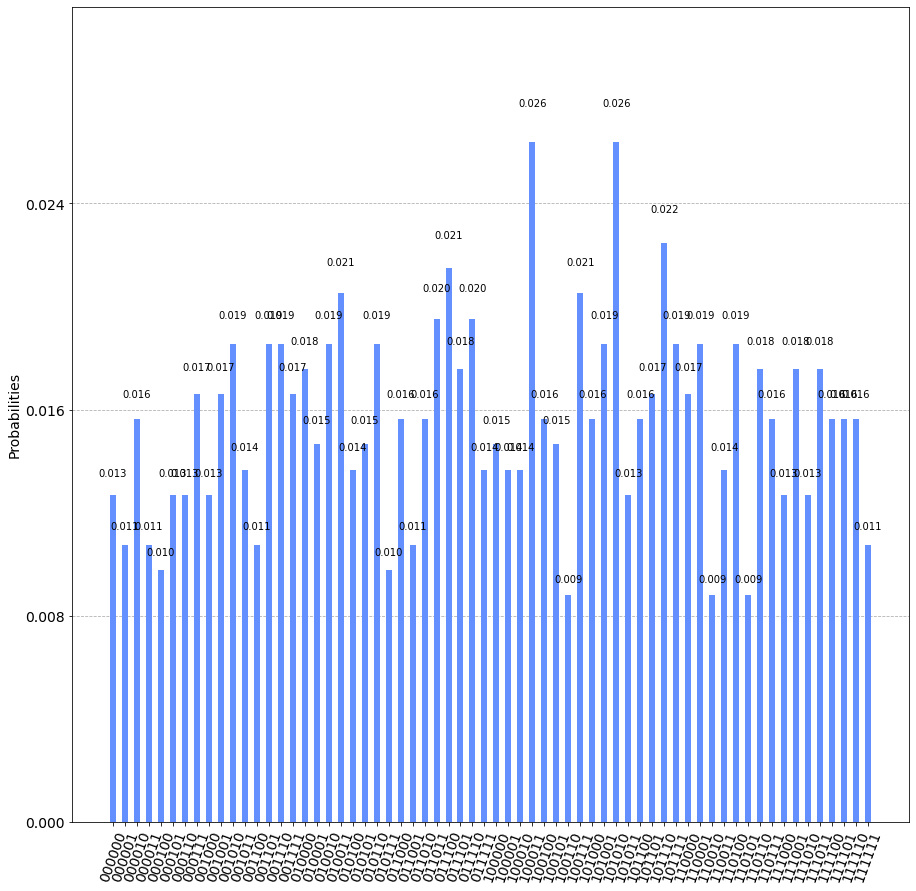

In [8]:
# Visualizing the Probability Distribution - Basic QAOA
counts = basic_qaoa(non_G, theta_basic)
print("Basic QAOA : ", res_basic.fun)
plot_histogram(counts, figsize = (15,15))

Multi-Angle QAOA :  -3.9931640625


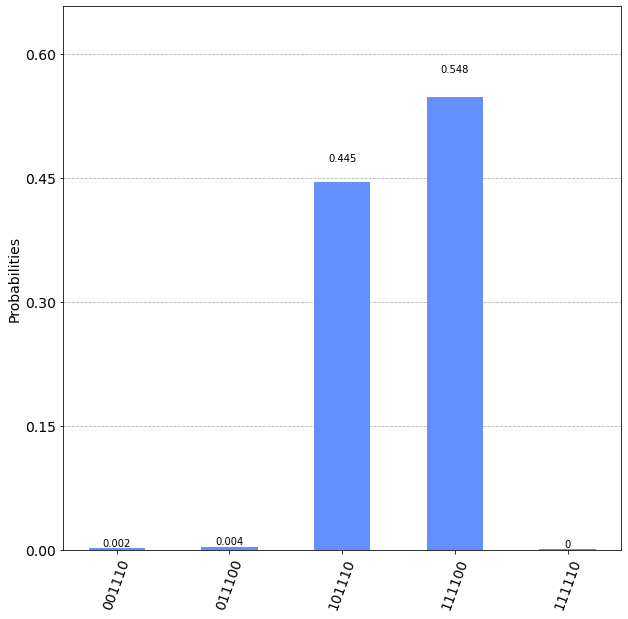

In [9]:
# Visualizing the Probability Distribution - Multi QAOA
counts_multi = multi_angle_qaoa(non_G, theta_multi)
print("Multi-Angle QAOA : ", res_multi.fun)
plot_histogram(counts_multi, figsize = (10,10))

In [10]:
# Comparing the Results
keymax = max(zip(counts_multi.values(), counts_multi.keys()))
value = max_clique(keymax[1], non_G)

AR_basic = res_basic.fun/value
AR_multi = res_multi.fun/value

print("Approximation Ratio by Basic QAOA       : ", AR_basic)
print("Approximation Ratio by Multi-Angle QAOA : ", AR_multi)

Approximation Ratio by Basic QAOA       :  0.3896484375
Approximation Ratio by Multi-Angle QAOA :  0.998291015625
